# Lab 2: Linear Models
This lab, like the others that follow it, will be a small, largely self-guided project in building a machine learning model.
You will write a logistic regression classifier, from scratch, to classify 28x28 pixel images of handwritten digits (0 - 9) by which digit appears in the image.
This is [the famous MNIST dataset](http://yann.lecun.com/exdb/mnist/), which has 60,000 training examples and 10,000 test examples.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# Any other imports you need go here

## Section 0: download the data
Download the data as a CSV [here](https://pjreddie.com/projects/mnist-in-csv/) (the original data format is very unfriendly) and read the data format on the website.

## Section 1: load, understand, and preprocess the data
Load the data from disk into four numpy arrays: x_train (feature vectors from the training set), y_train (labels from the training set), x_test (feature vectors from the test set), and y_test (labels from the test set).

Then, do some simple preprocessing.
Normalize your features by subtracting the mean and dividing by the range.
This is less important for linear models, but is generally good practice and will be much more important with more complex models.
Make sure you don't use any values computed from the test set, just the mean and range of the training set.

Finally, display one of the training images, and print its correct label.

Functions to look at:
 - `np.loadtxt`
 - `np.reshape`
 - `plt.imshow`

In [2]:
train_data = np.loadtxt('data/mnist_train.csv', delimiter=',')
test_data = np.loadtxt('data/mnist_test.csv', delimiter=',')

In [3]:
x_train = train_data[:,1:]
y_train = train_data[:,0]

x_test = test_data[:,1:]
y_test = test_data[:,0]

In [4]:
mean = np.mean(x_train)
max_val = np.max(x_train)
min_val = np.min(x_train)
for i in range(x_train.shape[0]):
    x_train[i] = (x_train[i] - mean) / (max_val - min_val)  
    
for i in range(x_test.shape[0]):
    x_test[i] = (x_test[i] - mean) / (max_val - min_val)     

The label for this image is:  5


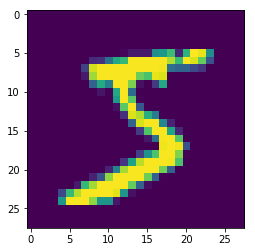

In [5]:
img = train_data[0,1:]
label = train_data[0,0]
dim = np.sqrt(img.shape[0]).astype(int)
plt.imshow(np.reshape(img, (dim, dim)))
print("The label for this image is: ", label.astype(int))

## Section 2: build a data pipeline
Make a pipeline that turns the dataset you have in numpy arrays into tensors that your model can use.
The pipeline should also shuffle and batch the data (with some reasonable batch size; I used 64 because I'm training on a GPU but you might want to go lower).

There are multiple ways to approach this.
No matter what, you'll need two `tf.data.Dataset`s, one for train and one for test, and probably you'll do some transforms to that.
I made datasets which did not use `repeat`, and used reinitializable iterators to feed the data -- you might instead repeat the data for as many epochs (full run-throughs of the dataset during training, ~5-10 for this assignment) as you plan to train for, then use one-shot iterators instead, or do something else.
Don't use feeding to pass in your data, though, since it'll result in a slow pipeline.

Optionally, you might want to cache or prefetch data to prevent it from being loaded multiple times while the model is training and keep the model from needing to wait for data.

Now might also be a good place to convert the labels to one-hot encoding (see below), though you don't need to.
If you want, you could also do your data normalization on-the-fly here (but make sure it still does the same thing).

Functions to look at (not exhaustive):
 - `tf.data.Dataset.from_tensor_slices`
 - `tf.data.Dataset.shuffle`
 - `tf.data.Dataset.batch`
 - `tf.data.Dataset.repeat`
 - `tf.data.Dataset.make_one_shot_iterator`
 - `tf.data.Dataset.make_initializable_iterator`
 - `tf.data.Iterator.from_structure`
 - `tf.data.Iterator.make_initializer`

In [6]:
n_epochs = 10
batch_size = 32
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))\
    .shuffle(500).batch(batch_size).cache()
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))\
    .shuffle(500).batch(batch_size).cache()

In [7]:
iterator = tf.data.Iterator.from_structure(
    dataset_train.output_types, 
    dataset_train.output_shapes)

train_init_op = iterator.make_initializer(dataset_train)
test_init_op = iterator.make_initializer(dataset_test)

Instructions for updating:
Colocations handled automatically by placer.


## Section 3: build a model graph
This is where the actual model gets built.
I'll give you the steps, but there's flexibility in how you implement each part.
Make sure your design is clean, both for efficiency and ease of debugging.
Names and name scopes help divide the model into logical parts.

Note that the first axis of every tensor will be the batch size.
So, a tensor that in your model is a scalar will likely have a shape of (?), and a 10-element vector will have a shape of (?, 10).
The "?" indicates that TensorFlow will treat this axis as being variable-length, since it can't infer it just from context.
It may be helpful to switch your thinking back and forth from one view (no batches, scalars are scalars) when thinking about modeling to another (scalars come in batches) when writing code that changes shapes.

If you're having difficulty debugging, try looking at your graph in TensorBoard, printing tensor objects to see their shapes, and running small parts of the graph in a session while feeding values to certain tensors.

Functions to look at throughout:
 - `tf.cast`
 - `tf.expand_dims`
 - `tf.squeeze`
 - arithmetic operations

### 3.1: Input tensors
Get a tensor for the input image (features) and another tensor for the correct label.
It may be convenient to convert the label to a one-hot vector: 10 elements, each of which is 0 except the place of the correct label.
For instance, a label of "3" would be the vector $$[0, 0, 0, 1, 0, 0, 0, 0, 0, 0].$$

Functions to look at:
 - `tf.data.Iterator.get_next`
 - `tf.one_hot`

In [8]:
with tf.name_scope('inputs'):
    next_elem = iterator.get_next()
    features = next_elem[0]
    not_hot = tf.cast(next_elem[1], tf.int32)
    label = tf.one_hot(not_hot, 10) 

### 3.2: Variables
Logistic regression needs two variables, correctly shaped: a weight matrix and a vector of biases.

In [9]:
weights = tf.get_variable('weights', shape=(x_train.shape[1], 10), dtype=tf.float64,
                          initializer=tf.glorot_uniform_initializer())
bias = tf.get_variable('bias', shape=(10), dtype=tf.float64,
                       initializer=tf.zeros_initializer())

### 3.3: Logits
Compute the inputs to the softmax functiton, the logits or "unnormalized probabilities."
The result should be, for each example in the batch, a vector of ten values (so the tensor has a shape like (?, 10)).

In [10]:
logit = tf.matmul(features, weights) + bias

### 3.4: Softmax probabilities
Apply the softmax function to the logits to obtain a vector of class probabilities.
Again, there should be a probability for each class for each example.
Do _not_ use helper functions to compute the softmax function, like `tf.nn.softmax` or `tf.contrib.layers.softmax`.
Instead, stick to core operations like `tf.exp`.

Two main reasons for this:
 1. Better to learn without the API doing too much of the work for you; when doing model development it'll basically all be from scratch
 2. I couldn't get `tf.nn.softmax` to run on a GPU, so I'd do it this way in practice too

In [11]:
logit_exp = tf.exp(logit)
total_prob = tf.reduce_sum(logit_exp, axis=1)
probs = logit_exp / tf.reshape(total_prob, (tf.shape(logit_exp)[0], 1))

### 3.5: Cross-entropy loss
Compute the per-example cross-entropy loss $$L = -y \cdot \log p_\text{model}(y)$$ using the probabilities and the correct label.

Then, take the mean of the per-example losses to compute a per-batch loss.
Also, add a summary operation which saves the per-batch loss so you can plot it later.

In [12]:
ce_per_example = tf.cast(-label, tf.float64) * tf.log(probs)
ce_batch = tf.reduce_mean(ce_per_example)

tf.summary.scalar('loss', ce_batch)


<tf.Tensor 'loss:0' shape=() dtype=string>

### 3.6: The optimizer
Add an optimizer (simple gradient descent is fine) and an operation to minimize the per-batch loss.
You may need to play around with the learning rate to find one that works.

In [13]:
optimizer = tf.train.GradientDescentOptimizer(1e-1)
optimize_step = optimizer.minimize(ce_batch)

Instructions for updating:
Use tf.cast instead.


### 3.7: Predicted label and per-batch accuracy
The model should predict the digit it assigns the highest probability. 
Add a tensor which represents the predicted digit; this lets you use the model "in the wild".
Then, add a tensor which represents what fraction of the batch the model predicted correctly (its accuracy, or average 0/1 loss), and a summary operation for accuracy.

Finally, add a tensor to merge the summaries made so far.
Or, just add them one at a time if you want (but why would you?)

Functions to look at:
 - `tf.argmax`
 - `tf.equal`
 - `tf.reduce_mean`
 - `tf.summary.merge_all`

In [14]:
pred = tf.argmax(probs, axis=1)
correct = tf.argmax(label, axis=1)
num_correct = tf.reduce_sum(tf.cast(tf.equal(pred, correct), tf.float32))
accuracy = num_correct / tf.cast(tf.shape(probs)[0], tf.float32)

tf.summary.scalar('accuracy', accuracy)

merged_summaries = tf.summary.merge_all()

## Section 4: train the model
Make a training loop which iterates through the full training set multiple times, and, for each batch:
 1. Runs the training operation
 2. Adds the summaries to a training FileWriter, with the correct batch number

After each epoch, iterate over the test dataset, adding summaries to a test FileWriter, and print the average test accuracy over the whole test set.
Finally, use a `Saver` to save the whole graph to disk.

Remember to: 
 - Initialize variables
 - Give FileWriters references to the graph
 
Then, run training.
You should expect the model to hit about 90% test-set accuracy.
Not bad for a linear model!
If it doesn't, it might indicate a bug in your code, or you might need to tune hyperparameters (e.g. batch size, learning rate).
The accuracy should sharply jump after the first epoch, so you don't need to wait for the full model to train to know you have a bug. 

You might notice, looking at the training plots on TensorBoard, how close the training and test errors are.
This suggests our model is probably underfitting, and a more powerful model will do better.

<sup><sub>My model was showing 20% accuracy and it took over an hour to figure out I was actually just computing accuracy wrong :(</sub></sup>

In [15]:
saver = tf.train.Saver()

train_batch = 0
test_batch = 0

with tf.Session() as sess:
    # Make one writer for training logs and another for test logs 
    train_writer = tf.summary.FileWriter('./logs_lab/train', graph=sess.graph)
    test_writer = tf.summary.FileWriter('./logs_lab/test')
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Training loop
    for epoch in range(n_epochs):
        # Load training data
        sess.run(train_init_op)
        
        # Iterate over the dataset once
        while True:
            try:
                if train_batch > 0: # Typical batch
                    # Run summary ops and optimization
                    summary, _ = sess.run([merged_summaries, optimize_step])
                    train_writer.add_summary(summary, train_batch)
                    train_batch += 1
                else:
                    # On the first batch, run a full trace
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                    run_metadata = tf.RunMetadata()
                    
                    summary, _ = sess.run([merged_summaries, optimize_step],
                                          options=run_options,
                                          run_metadata=run_metadata)
                    
                    train_writer.add_summary(summary, train_batch)    
                    train_writer.add_run_metadata(run_metadata, 
                                                  'first training batch')
                    train_batch += 1
            except tf.errors.OutOfRangeError: # No more data
                break
                
        print('Epoch:', epoch)
        sess.run(test_init_op)
        losses = [] # Track average loss over test set
        while True:
            try:
                summary, loss = sess.run([merged_summaries, ce_batch])
                losses.append(loss)

                # Roughly align test batches with training batches
                test_writer.add_summary(summary, test_batch)
                test_batch += 6
            except tf.errors.OutOfRangeError:
                break
        average_loss = np.mean(losses)
        print('Average test set loss:', average_loss)
        
    # Save model
    saver.save(sess, './checkpoints_lab/model.ckpt')    

Epoch: 0
Average test set loss: 0.04704666251853884
Epoch: 1
Average test set loss: 0.03934331132247226
Epoch: 2
Average test set loss: 0.036258164409292484
Epoch: 3
Average test set loss: 0.03443450970157081
Epoch: 4
Average test set loss: 0.033287645474246466
Epoch: 5
Average test set loss: 0.03244808682777039
Epoch: 6
Average test set loss: 0.0317871224237376
Epoch: 7
Average test set loss: 0.0312739641146197
Epoch: 8
Average test set loss: 0.03092758385598421
Epoch: 9
Average test set loss: 0.03053621045979733


## Section 5: use the model for inference
Pull one or more examples from the test set and display its image.
Then, use your model to predict what digit the image is, print that, and print the true label (which hopefully matches).

Remember you'll need to use `Saver.restore()` to load the trained model before inference.

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoints_lab/model.ckpt
The label for this image is:  7
The prediction for this image is:  7


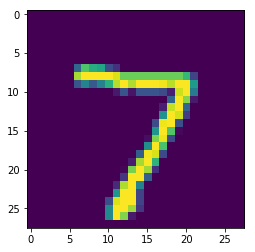

In [16]:
with tf.Session() as sess:
    saver.restore(sess, './checkpoints_lab/model.ckpt')
    sess.run(test_init_op)
    weights2 = weights.eval()
    bias2 = bias.eval()
    
    img = test_data[0,1:]
    label = test_data[0,0]
    dim = np.sqrt(img.shape[0]).astype(int)
    plt.imshow(np.reshape(img, (dim, dim)))
    print("The label for this image is: ", label.astype(int))
    
    pred_img = (np.reshape(img, (1,img.shape[0])) @ weights2) + bias2
    
    print("The prediction for this image is: ", np.argmax(pred_img))

## Section 6: visualizations
Visualize, as an image (i.e. `plt.imshow`), the weight matrix for each of the digits.
You might want to use the `vmin` and `vmax` arguments to put all of the matrices on the same scale. 
You'll need to load the weights again to save them to numpy arrays (by `run()`-ing the variables).

The results are pretty interesting.
The image should be brightest where the weights strongly indicate that digit, so you can see what's (linearly) characteristic of different digits -- I see a strong dark spot in the middle for zero, a distinctive curly tail on 2, and a consistent 3.
Other digits (e.g. 8 and 9) have much weaker patterns, suggesting greater variation in how people draw them.

INFO:tensorflow:Restoring parameters from ./checkpoints_lab/model.ckpt


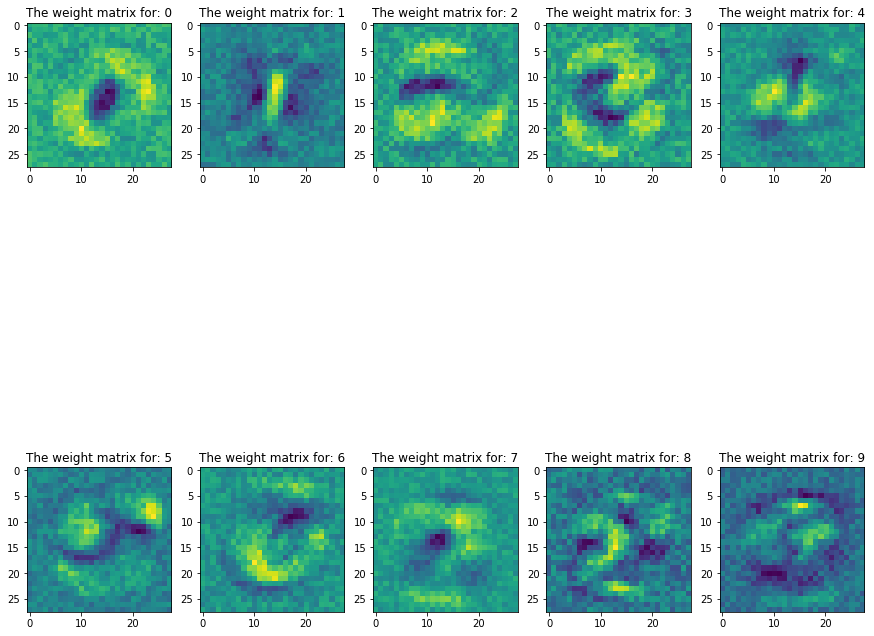

In [17]:
with tf.Session() as sess:
    saver.restore(sess, './checkpoints_lab/model.ckpt')
    sess.run(test_init_op)
    weights2 = weights.eval()
    fig, axs = plt.subplots(2, 5, figsize=(15, 15))
    axs = axs.flatten()
    for i in range(10):
        axs[i].imshow(np.reshape(weights2[:,i], (dim, dim)))
        axs[i].set_title("The weight matrix for: %d" % i)